In [2]:
import torch
from torchvision import datasets, transforms
# from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F

In [17]:
train_tf = transforms.Compose([transforms.Resize((128,128)),
                                
                                transforms.RandomRotation(20),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                ])
test_tf = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
trainset = datasets.ImageFolder('catvdog/train',transform=train_tf)
testset  = datasets.ImageFolder('catvdog/test',transform=test_tf)



trainloader = torch.utils.data.DataLoader(trainset,batch_size=120,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=120,shuffle=True)



In [4]:
#Functions for graphical representation
def imgshow(image, ax=None, title=None, normalize=True):
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
def view_classify(img, ps):
   
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 128, 128).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    
    
    
    ax2.set_yticklabels(['Cat',
                            
                            'Dog'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

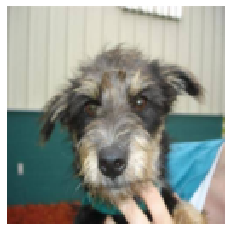

In [9]:
data = iter(testloader)
images,labels = data.next()
img = images[1]
imgshow(img,normalize=False)

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Convulational Layers
        self.cov1 = nn.Conv2d(3,16,3,padding=1)     #128x128x3
        self.cov2 = nn.Conv2d(16,32,3,padding=1)    #32x32x16    
        self.cov3 = nn.Conv2d(32,64,3,padding=1)    #16x16x32  
        self.cov4 = nn.Conv2d(64,96,3,padding=1)   #8x8x64 -> 4x4x96
          
        #Pooling Layers
        self.mp2x2 = nn.MaxPool2d(2,2)
        self.mp4x4 = nn.MaxPool2d(4,4)
        #Fully Connected Network
        self.fc1 = nn.Linear(4*4*96,500)
        self.fc2 = nn.Linear(500,200)
        self.fc3 = nn.Linear(200,10)
        self.fc4 = nn.Linear(10,2)
        self.dropout = nn.Dropout(p=0.25)
    def forward(self,x):
        x = self.mp4x4(F.relu(self.cov1(x)))
        x = self.mp2x2(F.relu(self.cov2(x)))
        x = self.mp2x2(F.relu(self.cov3(x)))
        x = self.mp2x2(F.relu(self.cov4(x)))
       

        x = x.view(-1,4*4*96)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x),dim=1)

        return x





In [6]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
model

Classifier(
  (cov1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cov2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cov3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cov4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp4x4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [14]:
torch.cuda.is_available()

True

In [20]:
epoches = 10
min_valid_loss = np.Inf
st_dict=torch.load('checkpoint.pth')
model.load_state_dict(st_dict)
model.cuda()
for e in range(epoches):
    run_loss = 0
    valid_loss = 0
    model.train()
    for images,labels in trainloader:
        images , labels = images.cuda(), labels.cuda()
        logps = model(images)
        loss = criterion(logps,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    model.eval()
    for images,labels in testloader:
        images,labels = images.cuda(),labels.cuda()
        logps=model(images)
        loss = criterion(logps,labels)
        valid_loss += loss.item()
    train_loss= run_loss/len(trainloader.sampler)
    validation_loss = valid_loss/len(testloader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, validation_loss))
    if validation_loss <= min_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        min_valid_loss,
        validation_loss))
        torch.save(model.state_dict(), 'validated.pth')
        min_valid_loss = validation_loss



Epoch: 0 	Training Loss: 0.003404 	Validation Loss: 0.003261
Validation loss decreased (inf --> 0.003261).  Saving model ...
Epoch: 1 	Training Loss: 0.003189 	Validation Loss: 0.003141
Validation loss decreased (0.003261 --> 0.003141).  Saving model ...
Epoch: 2 	Training Loss: 0.003107 	Validation Loss: 0.003067
Validation loss decreased (0.003141 --> 0.003067).  Saving model ...
Epoch: 3 	Training Loss: 0.003113 	Validation Loss: 0.003119
Epoch: 4 	Training Loss: 0.002992 	Validation Loss: 0.003158
Epoch: 5 	Training Loss: 0.002985 	Validation Loss: 0.002967
Validation loss decreased (0.003067 --> 0.002967).  Saving model ...
Epoch: 6 	Training Loss: 0.002959 	Validation Loss: 0.003040
Epoch: 7 	Training Loss: 0.002837 	Validation Loss: 0.002776
Validation loss decreased (0.002967 --> 0.002776).  Saving model ...
Epoch: 8 	Training Loss: 0.002828 	Validation Loss: 0.002776
Validation loss decreased (0.002776 --> 0.002776).  Saving model ...
Epoch: 9 	Training Loss: 0.002710 	Validat

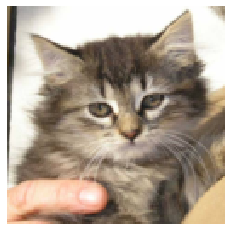

In [7]:
data = iter(testloader)
images,labels = data.next()
img = images[0]
imgshow(img,normalize=False)

In [21]:
st_dict=torch.load('validated.pth')
model.load_state_dict(st_dict)

<All keys matched successfully>

In [16]:

model.cuda()
img = img.cuda()
model.eval()
logps = model(img)

ps = torch.exp(logps)

ps
#view_classify(img, ps)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 16 3 3, but got 3-dimensional input of size [1, 128, 128] instead